In [ ]:
using SparseArrays
using LinearAlgebra
using NLopt
using PyPlot
using KrylovKit
using Statistics
using FiniteDifferences
using Revise
using IJulia
using TopologyOptimizationHelper

[ Info: Precompiling TopologyOptimizationHelper [b5275363-5667-4a27-81d8-f48bed5c410a]


In [34]:
Lx = 5
Ly = 5
res = 20
ε = ones(res * (Ly + 1), res * (Lx + 1))
ω = 2π

N, M = size(ε)
b = zeros(N, M)
b[N÷2, M÷2] = 1;

In [35]:
function LDOS_Optimize2d(Lx, Ly, ε, ω, b; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, design_dimensions=(Lx, Ly), α=0)
    A, x, y = Maxwell2d(Lx, Ly, ε, ω; dpml, resolution, Rpml)
    ε = vec(ε)
    b = vec(b)
    D² = A + spdiagm(ω^2 .* ε)
    M, N = length(x), length(y)
    LDOS_vals = Float64[]
    omegas = ComplexF64[]
    
    function LDOS_obj(ε, grad)
        ε = vec(ε)
        A = D² - spdiagm(ω^2 .* ε .* (1 + α * im))
        LDOS, ∇LDOS = ∇_ε_LDOS(A, ω, b; α)
        grad .= ∇LDOS
        push!(LDOS_vals, LDOS)

        IJulia.clear_output(true)  # Clear notebook output
        plt.clf()  # Clear the current figure, removes all previous plots
        
        figure(figsize=(6, 6))  # Fix the figure size to avoid shrinking
        imshow(reshape(ε, N,M), cmap="coolwarm", vmin=1, vmax=12)
        title("Iteration $(length(LDOS_vals)), LDOS = $LDOS")
        colorbar(label=L"ε_{opt}")

        display(gcf())  # Display the current figure in the notebook
        sleep(0.1)  # Pause to visualize the update

        A_now, _, _ = Maxwell2d(Lx, Ly, reshape(ε, N,M), ω; resolution=res)
        ω₀_now = sqrt(Arnoldi_eig(A_now, vec(ε), ω, vec(b))[1])
        push!(omegas, ω₀_now)
        return LDOS
    end

    design_x, design_y = design_dimensions
    x_indices = -design_x / 2 .< x .- mean(x) .< design_x / 2
    y_indices = -design_y / 2 .< y .- mean(y) .< design_y / 2
    ub = ones(N,M)
    ub[y_indices, x_indices] .= 12
    ub = vec(ub)
    
    opt = Opt(:LD_CCSAQ, M * N)
    opt.lower_bounds = 1
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.maxeval = max_eval
    opt.max_objective = LDOS_obj

    (LDOS_opt, ε_opt, ret) = optimize(opt, ε)
    A_opt, _, _ = Maxwell2d(Lx, Ly, ε_opt, ω; resolution=res)
    ω₀_opt = sqrt(Arnoldi_eig(A_opt, vec(ε_opt), ω, vec(b))[1])
    Q_opt = -real(ω₀_opt) / 2imag(ω₀_opt)
    
    IJulia.clear_output(true)  # Clear notebook output
    plt.clf()  # Clear the current figure, removes all previous plots

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀_opt
    @show Q_opt
    
    return LDOS_opt, reshape(ε_opt, N,M), LDOS_vals, omegas, x, y
end

LDOS_Optimize2d (generic function with 1 method)

In [36]:
function mod_LDOS_Optimize2d(Lx, Ly, ε, ω, b, x₀; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, design_dimensions=(Lx,Ly))
    A, x, y = Maxwell2d(Lx, Ly, ε, ω; dpml, resolution, Rpml)
    ε = vec(ε)
    b = vec(b)
    D² = A + ω^2 .* spdiagm(ε)
    M, N = length(x), length(y)
    mod_LDOS_vals = Float64[]
    mod_omegas = ComplexF64[]
    ω_old = ω
    u_old = ones(M * N)
    LDOS_old = ∇_ε_LDOS(A, ω, vec(b))[1]
    
    function mod_LDOS_obj(ε, grad)
        ε = vec(ε)
        E = spdiagm(ε)
        A = D² - real(ω_old)^2 .* E
        E⁻¹ = spdiagm(1 ./ ε)
        C = E⁻¹ * A
        LU = lu(C)
        vals, vecs, _ = eigsolve(z -> LU \ z, x₀, 1, :LM, Arnoldi())
        vals = sqrt.(1 ./ vals .+ real(ω_old)^2)
        # We could also just have * done here every time
        # Pros: outperforms old scheme (and this one)
        # Cons: monotonically decreases on some intervals
        ω₀, u₀ = vals[1], vecs[1]
        A₀ = D² - real(ω₀)^2 .* E
        v = A₀ \ b
        w = A₀' \ b
        
        LDOS = -imag(v' * b)
        if LDOS > LDOS_old
            # *
            # ω_old = ω₀

            # **
            ω_old, u_old = ω₀, u₀

            
            LDOS_old = LDOS
        else
            # *
            # ind = findmin(abs.(vals .- real(ω_old)))[2]

            # **
            ind = findmax([abs(dot(u_old, vec)) / (norm(u_old) * norm(vec)) for vec in vecs])[2]

            
            ω₀, u₀ = vals[ind], vecs[ind]
            A₀ = D² - real(ω₀)^2 .* E
            v = A₀ \ b
            w = A₀' \ b
        end
        
        reals = real.(vals)
        imaginaries = imag.(vals)
        if !isempty(grad) 
            ∂LDOS_∂ε = -imag.(real(ω₀)^2 .* conj.(v) .* w)
            ∂LDOS_∂ω = -imag(2real(ω₀) .* v' * E * w)
            ∂ω_∂ε = -ω₀ .* u₀.^2 ./ 2sum(u₀.^2 .* ε)
            ∇LDOS = ∂LDOS_∂ε .+  ∂LDOS_∂ω .* real.(∂ω_∂ε)

            grad .= ∇LDOS
        end

        push!(mod_LDOS_vals, LDOS)
        push!(mod_omegas, ω₀)

        IJulia.clear_output(true)  # Clear notebook output
        plt.clf()  # Clear the current figure, removes all previous plots
        
        fig, ax = plt.subplots(1,2, figsize=(15, 5))  # Fix the figure size to avoid shrinking
        ε_graph = ax[1].imshow(reshape(ε, N,M), cmap="coolwarm", vmin=1, vmax=12)
        ax[1].set_title("Iteration $(length(mod_LDOS_vals)), LDOS = $LDOS")
        plt.colorbar(ε_graph, label=L"ε_{opt}", ax=ax[1])

        ax[2].scatter(reals[2:end], imaginaries[2:end], color="blue")
        ax[2].scatter(reals[1], imaginaries[1], color="red")
        ax[2].scatter(real(ω_old), imag(ω_old), color="green")
        ax[2].set_xlim(6,6.5)
        ax[2].set_ylim(-0.5, 0.01)

        display(gcf())  # Display the current figure in the notebook
        sleep(0.1)  # Pause to visualize the update

        return LDOS
    end

    function freq_constraint(ε, grad)
        ω₀, ∂ω_∂ε = Eigengradient(A, ε, ω, x₀)
        if !isempty(grad) 
            grad .= -real.(∂ω_∂ε)
        end

        return ω - real(ω₀)
    end

    design_x, design_y = design_dimensions
    x_indices = -design_x / 2 .< x .- mean(x) .< design_x / 2
    y_indices = -design_y / 2 .< y .- mean(y) .< design_y / 2
    ub = ones(N,M)
    ub[y_indices, x_indices] .= 12
    ub = vec(ub)
    
    opt = Opt(:LD_CCSAQ, M * N)
    # opt.params["verbosity"] = 1
    opt.lower_bounds = 1
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.maxeval = max_eval
    opt.max_objective = mod_LDOS_obj
    opt.initial_step = 1e-3
    inequality_constraint!(opt, freq_constraint)

    (mod_LDOS_opt, mod_ε_opt, ret) = optimize(opt, ε)
    A_opt, _, _ = Maxwell2d(Lx, Ly, mod_ε_opt, ω; resolution=res)
    ω₀_opt = sqrt(Arnoldi_eig(A_opt, vec(mod_ε_opt), ω, vec(b))[1])
    Q_opt = -real(ω₀_opt) / 2imag(ω₀_opt)
    
    IJulia.clear_output(true)  # Clear notebook output
    plt.clf()

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀_opt
    @show Q_opt
    
    return mod_LDOS_opt, reshape(mod_ε_opt, N,M), mod_LDOS_vals, mod_omegas, x, y
end

mod_LDOS_Optimize2d (generic function with 1 method)

numevals = opt.numevals = 100
ω₀_opt = 6.282666187170308 - 0.005920494349726059im
Q_opt = 530.5862835137243
LDOS_opt = 0.17593147095409295


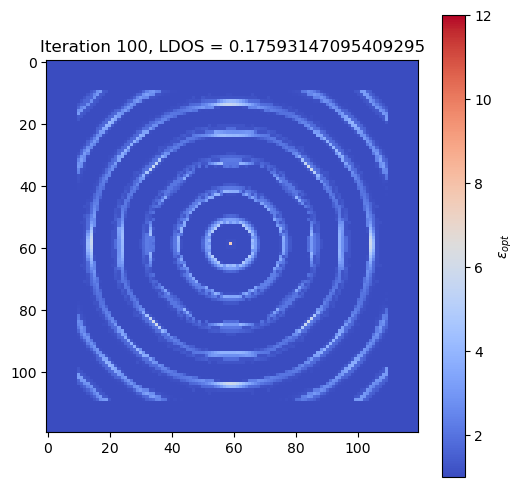

PyObject <matplotlib.colorbar.Colorbar object at 0x000002A1A85A7D60>

In [37]:
LDOS_opt, ε_opt, LDOS_vals, omegas, x, y = LDOS_Optimize2d(Lx, Ly, ε, ω, b; resolution=res, max_eval=100, ftol=0, α=0)
@show LDOS_opt
imshow(ε_opt, cmap="coolwarm", vmin=1, vmax=12)
title("Iteration $(length(LDOS_vals)), LDOS = $LDOS_opt")
colorbar(label=L"ε_{opt}")

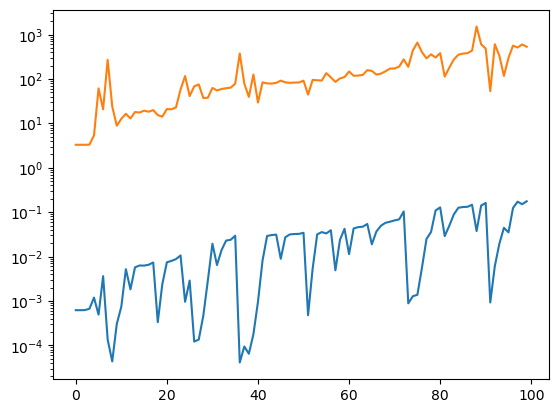

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000002A18FD028F0>

In [38]:
semilogy(LDOS_vals)
semilogy(-real.(omegas) ./ 2imag.(omegas))

numevals = opt.numevals = 100
ω₀_opt = 6.286198297409275 - 0.0007808240333302054im
Q_opt = 4025.361687830427
mod_LDOS_opt = 1.3721676298787835


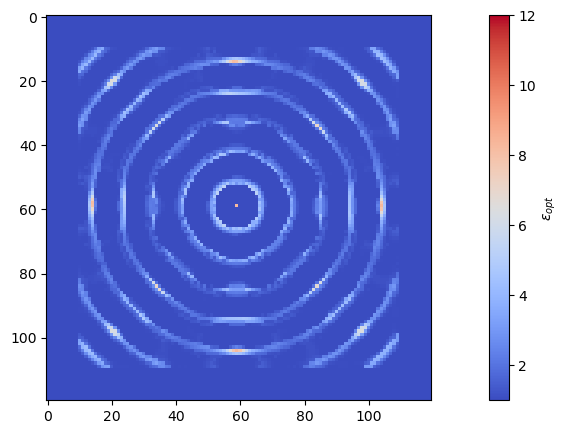

PyObject <matplotlib.colorbar.Colorbar object at 0x000002A1A864AA40>

In [39]:
mod_LDOS_opt, mod_ε_opt, mod_LDOS_vals, mod_omegas, _, _ = mod_LDOS_Optimize2d(Lx, Ly, ε_opt, ω, b, vec(b); resolution=res, max_eval=100, ftol=0)
@show mod_LDOS_opt
imshow(mod_ε_opt, cmap="coolwarm", vmin=1, vmax=12)
colorbar(label=L"ε_{opt}")

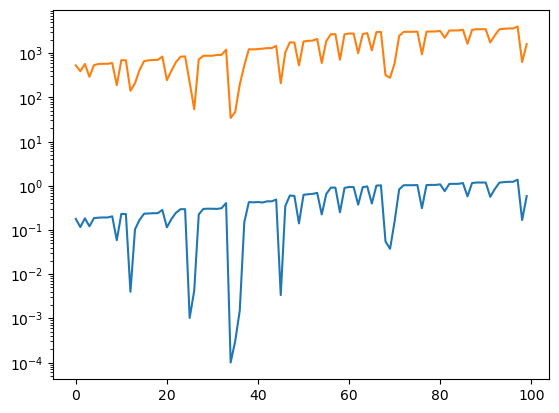

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000002A18FD31DB0>

In [40]:
semilogy(mod_LDOS_vals)
semilogy(-real.(mod_omegas) ./ 2imag.(mod_omegas))

In [9]:
_, ε_1, LDOS_vals_1, omegas_1, _, _ = LDOS_Optimize2d(Lx, Ly, ε, ω, b; resolution=res, max_eval=500, ftol=0, α=1)

numevals = opt.numevals = 500
ω₀_opt = 6.231776713274127 - 0.002621878637595457im
Q_opt = 1188.4182249925443


(0.0012796493403622721, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [0.0004774905574787754, 0.00047770093555719965, 0.0004798045498822509, 0.0005100386847240593, 0.0008612615725891896, 0.0010985109880017553, 0.0011043037312996066, 0.0011465716878983272, 0.00050639371718175, 0.0010428711670860673  …  0.0012796493169149284, 0.0012796493195642697, 0.0012796493222023949, 0.0012796493248293968, 0.0012796493274453793, 0.001279649330050435, 0.001279649332644654, 0.001279649335228155, 0.0012796493378010249, 0.0012796493403622721], ComplexF64[6.1553083860248945 - 0.9340405423870004im, 6.155307305862293 - 0.9340401377862111im, 6.1552964917532 - 0.9340360871350079im, 6.155138321271197 - 0.9339767191411243im, 6.159991984707599 - 0.9300811327672441im, 6.160741114309795 - 0.9173210004668317im, 6.161270238464431 - 0.9190643253740568im, 6.821904293720717 - 0.5114825964978579im, 6.227395257882671 - 0.3361114064808986im, 6.093729305768536 - 0.8677361491860409im  …  

In [10]:
_, ε_2, LDOS_vals_2, omegas_2, _, _ = LDOS_Optimize2d(Lx, Ly, ε_1, ω, b; resolution=res, max_eval=500, ftol=0, α=0.5)

numevals = opt.numevals = 500
ω₀_opt = 6.244911919733344 - 4.815086796116662e-5im
Q_opt = 64847.34527288093


(0.002082270352536343, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [0.001938244878447342, 0.0019391735655313435, 0.001948349018578046, 0.0019994820801083257, 0.0019688123911583266, 0.002038845196954289, 0.001974015742613279, 0.0020495294255625258, 0.0018142725804058024, 0.0020516945187968477  …  0.0020822702527203934, 0.00208227026388094, 0.002082270274995645, 0.0020822702861007154, 0.002082270297196284, 0.002082270308282493, 0.0020822703193594675, 0.0020822703304273498, 0.002082270341486265, 0.002082270352536343], ComplexF64[6.231776713274127 - 0.002621878637595457im, 6.231776707489108 - 0.0026218815014544547im, 6.23177664965325 - 0.002621910406238524im, 6.231775843252369 - 0.0026221762520910177im, 6.231765115251776 - 0.0026267196324523505im, 6.231771775936933 - 0.0026231433969481303im, 6.231729263142564 - 0.002627621177270055im, 6.231766140568913 - 0.0026231760636918986im, 6.28053769809967 - 0.00042520786884326137im, 6.231757859572237 - 0.0026235

In [12]:
_, ε_rest, LDOS_vals_rest, omegas_rest, _, _ = LDOS_Optimize2d(Lx, Ly, ε_2, ω, b; resolution=res, max_eval=2000, ftol=0, α=0)

numevals = opt.numevals = 2000
ω₀_opt = 6.283185306478349 - 1.7109203096098951e-7im
Q_opt = 1.8362004563236993e7


(964.0879418732846, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [2.134118353401604e-7, 2.1341260892989867e-7, 2.1342034508655403e-7, 2.1353179575574514e-7, 2.1514711702391205e-7, 2.4076830516414704e-7, 2.8629605650411773e-5, 6.291680248857771e-5, 0.00024864746302254165, 0.00029476340996962045  …  962.0690390675247, 679.5285268528288, 959.127665098373, 962.2645959427666, 957.4045166801691, 962.5802967239962, 856.7060477154043, 962.416683418421, 962.9193784471806, 964.0879418732846], ComplexF64[6.244911919733344 - 4.815086796116662e-5im, 6.244911918527971 - 4.8150869391349275e-5im, 6.2449119064742264 - 4.815088369080319e-5im, 6.244911732893252 - 4.8151089614456196e-5im, 6.24490923187784 - 4.815405657021918e-5im, 6.244872914509156 - 4.8197127113484106e-5im, 6.244280308034448 - 4.889716369861061e-5im, 6.298876457876421 - 0.004407570281033312im, 6.264826802657839 - 0.005474477552686012im, 6.284755435958239 - 0.008077002052743544im  …  6.283185308302569 

In [28]:
_, mod_ε_opt, mod_LDOS_vals, mod_omegas, _, _ = mod_LDOS_Optimize2d(Lx, Ly, mod_ε_opt, ω, b, vec(b); resolution=res, max_eval=100, ftol=0)

numevals = opt.numevals = 100
ω₀_opt = 6.286369879193852 - 1.3220282730796267e-7im
Q_opt = 2.3775474425179783e7


(21613.71930112936, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [14071.086746772664, 2.0748526605907195e-5, 2.0767707890453696e-5, 2.09604214815307e-5, 2.2993666112414364e-5, 6.138548954970845e-5, 2145.8846946156823, 12415.254553180226, 14023.56884130236, 14078.169138866228  …  19130.961923685914, 19130.938125418423, 8685.643895537987, 19301.91500804686, 19386.96912165979, 20252.092636339534, 20974.680173238063, 7461.70546675604, 21613.71930112936, 22503.891967902593], ComplexF64[6.286428050567509 - 2.0305641242811163e-7im, 6.353510033576959 - 1.117636594740654e-5im, 6.35347786958321 - 1.1188407401490702e-5im, 6.353157497216206 - 1.1310178799703774e-5im, 6.35006349633092 - 1.2675161225891498e-5im, 6.327530043836469 - 3.904905486992799e-5im, 6.288879005532642 - 1.3322381368724833e-6im, 6.283292428134197 - 2.2998818485504129e-7im, 6.284767455021628 - 2.0364463030131228e-7im, 6.286017346452487 - 2.0293294568493445e-7im  …  6.286359658390362 - 1.493581

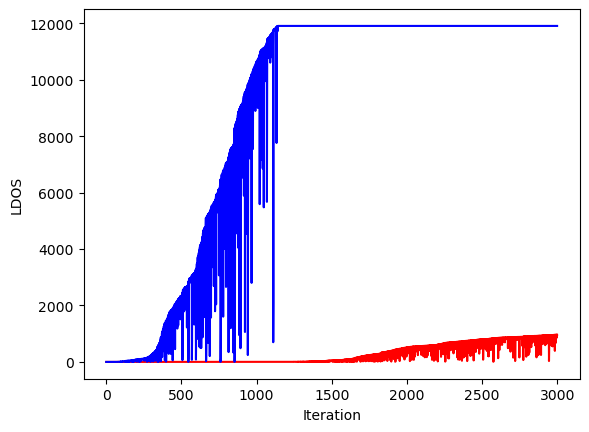

PyObject Text(24.0, 0.5, 'LDOS')

In [24]:
old_LDOSes = vcat(LDOS_vals_1, LDOS_vals_2, LDOS_vals_rest)
new_LDOSes = vcat(LDOS_vals, mod_LDOS_vals)

plot(old_LDOSes, color="red")
plot(new_LDOSes, color="blue")

xlabel("Iteration")
ylabel("LDOS")

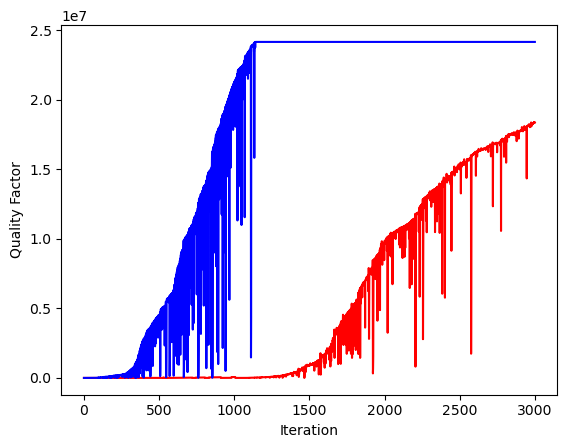

PyObject Text(24.000000000000007, 0.5, 'Quality Factor')

In [23]:
Qs = -real.(omegas) ./ 2imag(omegas)
Qs1 = -real.(omegas_1) ./ 2imag(omegas_1)
Qs2 = -real.(omegas_2) ./ 2imag(omegas_2)
Qsrest = -real.(omegas_rest) ./ 2imag(omegas_rest)
mod_Qs = -real.(mod_omegas) ./ 2imag(mod_omegas)

old_Qs = vcat(Qs1, Qs2, Qsrest)
new_Qs = vcat(Qs, mod_Qs)

plot(old_Qs, color="red")
plot(new_Qs, color="blue")

xlabel("Iteration")
ylabel("Quality Factor")